In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as udata
import torch.optim as optim

#from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

In [2]:
epochs        = 30
n_layers      = 3
n_nodes       = 36
n_outputs     = 2
drop_out_p    = 0.0
learning_rate = 0.001
#learning_rate = 0.01
batch_size    = 1000
verbose       = True

# x=60um  y=72um
# tanh
# adam
# pmax>10 && pmax>5

In [15]:
path = './'
df_train = pd.read_csv('csv_croci450-RSD2_Run111_285V_49.3pc_W3.csv', sep=',')
#df_t = pd.read_csv('csv_TB3_Run21_croci450um_W3_285V_150kWfm.csv', sep=',')
df_test = pd.read_csv('csv_TB3_Run20_croci450um_W3_285V_40kWfm.csv', sep=',')

df_train = df_train.dropna(axis=1)
df_test = df_test.dropna(axis=1)
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Train = df_train
Test = df_test

#x_low = -1
#x_up = 1
#y_low = -0.6
#y_up = 0.8
x_low = -5.475
x_up = -4.575
y_low = -1.232
y_up = -0.332


train = Train[ (Train['x_tracker']>(x_low) ) & (Train['x_tracker']<(x_up)) \
              & (Train['y_tracker']>(y_low)) & (Train['y_tracker']<(y_up)) ]

test = Test[ (Test['x_tracker']>x_low) & (Test['x_tracker']<x_up) & (Test['y_tracker']>y_low) \
              & (Test['y_tracker']<y_up) ]

train['x_tracker'] += -0.05
#test ['x_tracker'] += 5.0
train['y_tracker'] += 0.05
#test ['y_tracker'] += 1.0

train = train[ (train['pmax6']>train['pmax1']) & (train['pmax6']>train['pmax2']) & (train['pmax6']>train['pmax3']) \
        & (train['pmax6']>train['pmax4']) & (train['pmax6']>train['pmax5']) & (train['pmax6']>train['pmax7']) \
        & (train['pmax6']>train['pmax8']) & (train['pmax6']>train['pmax9']) & (train['pmax6']>train['pmax11']) \
        & (train['pmax6']>train['pmax12']) & (train['pmax6']>train['pmax13']) & (train['pmax6']>train['pmax14']) ]

test = test[ (test['pmax6']>test['pmax1']) & (test['pmax6']>test['pmax2']) & (test['pmax6']>test['pmax3']) \
        & (test['pmax6']>test['pmax4']) & (test['pmax6']>test['pmax5']) & (test['pmax6']>test['pmax7']) \
        & (test['pmax6']>test['pmax8']) & (test['pmax6']>test['pmax9']) & (test['pmax6']>test['pmax11']) \
        & (test['pmax6']>test['pmax12']) & (test['pmax6']>test['pmax13']) & (test['pmax6']>test['pmax14']) ]

train = train[ (train['pmax6']>=10) ]
test = test[ (test['pmax6']>=5) ]
train = train[ (train['pmax6']<=40) ]
test = test[ (test['pmax6']<=40) ]
train = train[ (train['negpmax6']>=-15) ]
test = test[ (test['negpmax6']>=-15) ]
train = train[ (train['negpmax3']>=-15) & (train['negpmax4']>=-15) & (train['negpmax5']>=-15) & (train['negpmax7']>=-15) & (train['negpmax8']>=-15) & (train['negpmax9']>=-15) \
             & (train['negpmax11']>=-15) & (train['negpmax14']>=-15) ]
test = test[ (test['negpmax3']>=-15) & (test['negpmax4']>=-15) & (test['negpmax5']>=-15) & (test['negpmax7']>=-15) & (test['negpmax8']>=-15) & (test['negpmax9']>=-15) \
             & (test['negpmax11']>=-15) & (test['negpmax14']>=-15) ]

print("Total training events = ", len(train), len(test))

y_train = train.iloc[:,:2]
x_train = train.drop(['x_tracker','y_tracker','x_rsd','y_rsd','t','t_reco','pmax0','negpmax0','tmax0'],axis=1)
x_train = x_train.drop(['pmax1','pmax2','pmax12','pmax13','negpmax1','negpmax2','negpmax12','negpmax13'],axis=1)
x_train = x_train.iloc[:,:18]
#x_train = x_train.iloc[:,:26]
#x_train['diff3'] = x_train['pmax3']+x_train['negpmax3']


y_test = test.iloc[:,:2]
x_test = test.drop(['x_tracker','y_tracker','x_rsd','y_rsd','t','t_reco','pmax0','negpmax0','tmax0'],axis=1)
x_test = x_test.drop(['pmax1','pmax2','pmax12','pmax13','negpmax1','negpmax2','negpmax12','negpmax13'],axis=1)
x_test = x_test.iloc[:,:18]
#x_test = x_test.iloc[:,:26]
#x_test['diff3'] = x_test['pmax3']+x_test['negpmax3']

n_var     = len(x_test.columns)
n_outputs = len(y_test.columns)
print(x_test.columns, n_var)
print(y_test.columns, n_outputs)

#for column in x_train.columns:
    #x_train[column] = (x_train[column]-x_train[column].mean(axis=0)) / x_train[column].std()
    #x_train[column] = x_train[column] / 3.
    #x_test[column] = (x_test[column]-x_test[column].mean(axis=0)) / x_test[column].std()
    #x_test[column] = x_test[column] / 3.
    

#s_train_y = 3*y_train.std()
#s_test_y = 3*y_test.std()
#s_train_y = []
#s_test_y = []
#y_train = (y_train - y_train.mean(axis=0))/3*y_train.std()
#y_test = (y_test - y_test.mean(axis=0))/3*y_test.std()
#for column in y_train.columns:
    #y_train[column] = (y_train[column]-y_train[column].mean(axis=0)) / y_train[column].std()
    #y_train[column] = y_train[column] / 3.
    #s_train_y.append(3*y_train[column].std())
    #y_test[column] = (y_test[column]-y_test[column].mean(axis=0)) / y_test[column].std()
    #y_test[column] = y_test[column] / 3.
    #s_test_y.append(3*y_test[column].std())


y_train = torch.tensor(y_train.values)
x_train = torch.tensor(x_train.values)

y_test = torch.tensor(y_test.values)
x_test = torch.tensor(x_test.values)

#s_train_y = torch.tensor(s_train_y.values)
#s_test_y = torch.tensor(s_test_y.values)


#plt.figure(figsize=(10,10))
#plt.xlabel("x [mm]")
#plt.ylabel("y [mm]")
#plt.scatter(y_train[:,0], y_train[:,1], alpha=.3)
#plt.scatter(y_test[:,0], y_test[:,1], alpha=.8)


m_train = x_train.mean(0, keepdim=True)
s_train = x_train.std(0, unbiased=False, keepdim=True)
x_train -= m_train
x_train /= 3*s_train

m_train_y = y_train.mean(0, keepdim=True)
s_train_y = y_train.std(0, unbiased=False, keepdim=True)
y_train -= m_train_y
y_train /= 3*s_train_y

m_test = x_test.mean(0, keepdim=True)
s_test = x_test.std(0, unbiased=False, keepdim=True)
x_test -= m_test
x_test /= 3*s_test

m_test_y = y_test.mean(0, keepdim=True)
s_test_y = y_test.std(0, unbiased=False, keepdim=True)
y_test -= m_test_y
y_test /= 3*s_test_y


train_tensor = udata.TensorDataset(x_train, y_train) 
test_tensor  = udata.TensorDataset(x_test,  y_test) 


loader_train = udata.DataLoader(dataset=train_tensor, batch_size=batch_size, num_workers=0, shuffle=True)
loader_test  = udata.DataLoader(dataset=test_tensor,  batch_size=batch_size, num_workers=0, shuffle=True)

Total training events =  21914 845
Index(['pmax3', 'pmax4', 'pmax5', 'pmax6', 'pmax7', 'pmax8', 'pmax9', 'pmax11',
       'pmax14', 'negpmax3', 'negpmax4', 'negpmax5', 'negpmax6', 'negpmax7',
       'negpmax8', 'negpmax9', 'negpmax11', 'negpmax14'],
      dtype='object') 18
Index(['x_tracker', 'y_tracker'], dtype='object') 2


/tmp/ipykernel_1088/1981634831.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['x_tracker'] += -0.05
/tmp/ipykernel_1088/1981634831.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y_tracker'] += 0.05


In [16]:
epochs        = 3
n_layers      = 3
n_nodes       = 36
n_outputs     = 2
drop_out_p    = 0.0
learning_rate = 0.001
#learning_rate = 0.01
batch_size    = 1000
verbose       = True

In [17]:
# Model
class DNN(nn.Module):
    def __init__(self, n_var, n_layers, n_nodes, n_outputs, drop_out_p):
        super(DNN, self).__init__()
        torch.manual_seed(1234)
        layers = []
        layers.append(nn.Linear(n_var, n_nodes))
        #layers.append(nn.ReLU())
        layers.append(nn.Tanh())

        for n in list(n_nodes for x in range(n_layers)):
            print(n)
            layers.append(nn.Linear(n, n))
            #layers.append(nn.ReLU())
            layers.append(nn.Tanh())
            layers.append(nn.BatchNorm1d(n))

        layers.append(nn.Dropout(p=drop_out_p))
        layers.append(nn.Linear(n_nodes, n_outputs))

        self.dnn = nn.Sequential(*layers)
        self.double()

    def forward(self, x):
        return self.dnn(x)

model = DNN(n_var=n_var, n_layers=n_layers, n_nodes=n_nodes, n_outputs=n_outputs, drop_out_p=drop_out_p)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=1e-3)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay=1e-3)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95, last_epoch=-1, verbose=verbose)

36
36
36
Adjusting learning rate of group 0 to 1.0000e-03.


In [18]:
# training and validation
training_losses_total = np.zeros(epochs)
validation_losses_total = np.zeros(epochs)

for epoch in range(epochs):
    if verbose: print("Beginning epoch " + str(epoch))
    # training
    train_loss_total = 0
    for i, data in enumerate(loader_train,0):
        x, y = data
        #x = data[0]
        #y = data[1]
        model.train()
        model.zero_grad()
        optimizer.zero_grad()
        output = model(x)
        #print(output)
        #print(x)
        #break
        batch_loss_total = criterion(output, y)        
        batch_loss_total.backward()
        optimizer.step()
        model.eval()
        train_loss_total += batch_loss_total.item()
    train_loss_total /= len(loader_train)
    training_losses_total[epoch] = train_loss_total
    if np.isnan(train_loss_total):
        print("nan in training")
        break
    if verbose: print("t_total: "+ str(train_loss_total))

    # validation
    val_loss_total = 0
    for i, data in enumerate(loader_test):
        x, y = data
        #x = data[0]
        #y = data[1]
        output = model(x)
        batch_loss_total = criterion(output, y)        
        val_loss_total += batch_loss_total.item()
    val_loss_total /= len(loader_test)
    scheduler.step()
    validation_losses_total[epoch] = val_loss_total
    if np.isnan(val_loss_total):
        print("nan in val")
        break
    if verbose: print("v_total: "+ str(val_loss_total))
    
    # save the model
    model.eval()
    #modelLocation = "{}/net_{}.pth".format(".",epoch)
    #torch.save(model.state_dict(), modelLocation)
    
print("Finished")
print("Final loss train:", training_losses_total[-1])
print("Final loss test:",  validation_losses_total[-1])

Beginning epoch 0
t_total: 0.10760007497134491
Adjusting learning rate of group 0 to 9.5000e-04.
v_total: 0.07978125534702132
Beginning epoch 1
t_total: 0.05230157527170216
Adjusting learning rate of group 0 to 9.0250e-04.
v_total: 0.051296976452451556
Beginning epoch 2
t_total: 0.04753098906986706
Adjusting learning rate of group 0 to 8.5737e-04.
v_total: 0.048227117814048405
Finished
Final loss train: 0.04753098906986706
Final loss test: 0.048227117814048405


Making basic validation plots


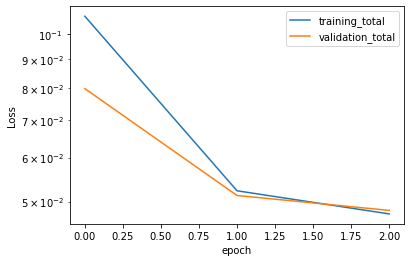

In [19]:
# plot loss/epoch for training and validation sets
print("Making basic validation plots")
training_total = plt.plot(training_losses_total, label='training_total')
validation_total = plt.plot(validation_losses_total, label='validation_total')
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("loss_plot.png")

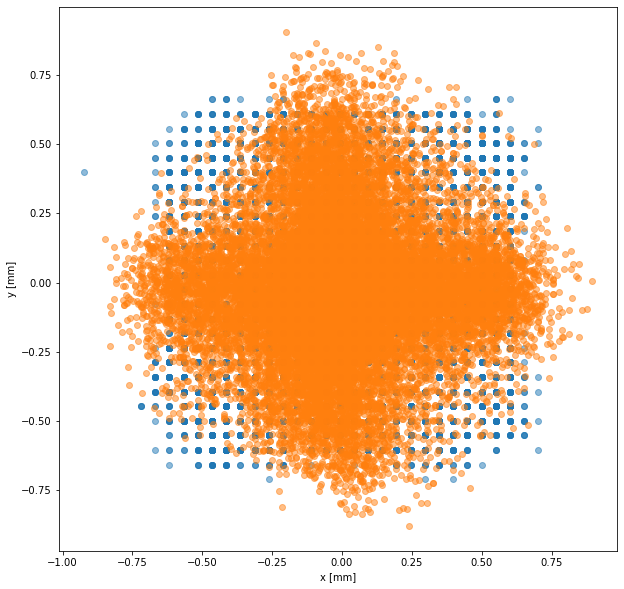

In [20]:
plt.figure(figsize=(10,10))
#plt.xlim(-10.0,10.0)
#plt.ylim(-10.0,10.0)
#plt.xlim(-2.0,2.0)
#plt.ylim(-2.0,2.0)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

plt.scatter(y_train[:,0], y_train[:,1], alpha=.5)
plt.scatter(model(x_train).detach().numpy()[:,0], model(x_train).detach().numpy()[:,1], alpha=.5)

#plt.savefig('/home/federico/Scrivania/croci450_2d.png')

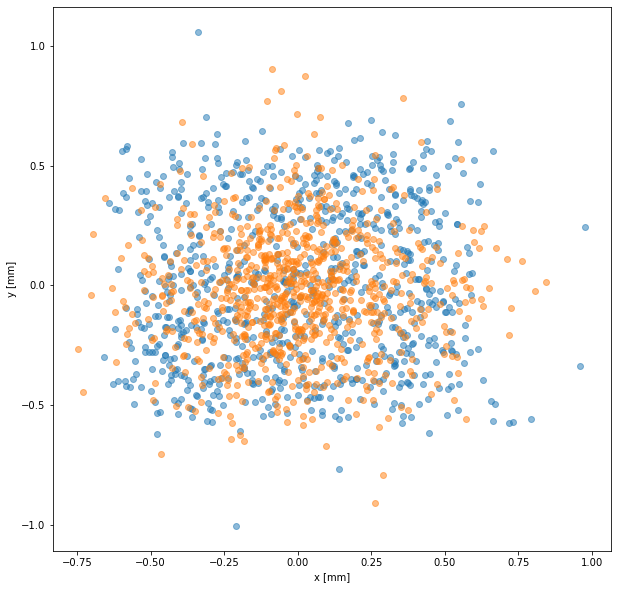

In [21]:
plt.figure(figsize=(10,10))
#plt.xlim(-10.0,10.0)
#plt.ylim(-10.0,10.0)
#plt.xlim(-2.0,2.0)
#plt.ylim(-2.0,2.0)
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")

model.eval()

plt.scatter(y_test[:,0], y_test[:,1], alpha=.5)
plt.scatter(model(x_test).detach().numpy()[:,0], model(x_test).detach().numpy()[:,1], alpha=.5)

#plt.savefig('/home/federico/Scrivania/croci450_2d.png')

Sigma x-axis: 0.0824221130548328
Sigma y-axis: 0.08370757795967204


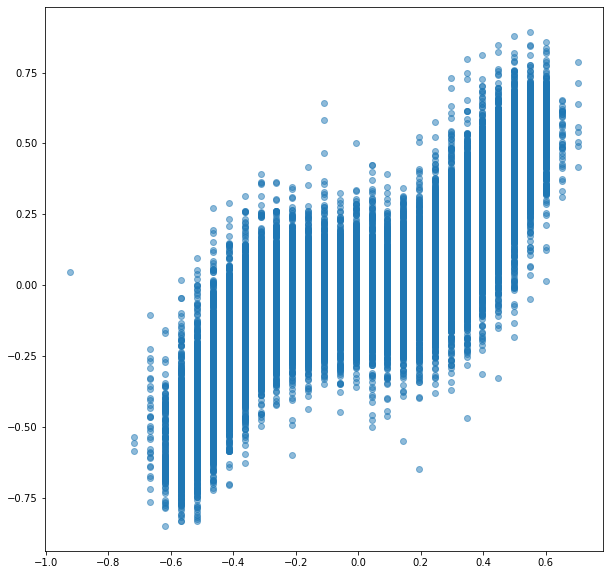

In [22]:
plt.figure(figsize=(10,10))

yhat = model(x_train).detach().numpy()
#yhat = model(x_train)
#y_train.subtract(yhat)
#y_res = y_train.div(3*s_train_y)
yres = (y_train-yhat)*3*s_train_y
plt.scatter(y_train[:,0],yhat[:,0],alpha=.5)

hist_x = yres[1:,0]
hist_y = yres[1:,1]

mu_x, sigma_x = norm.fit(yres)
mu_y, sigma_y = norm.fit(hist_y)
print('Sigma x-axis: '+str(sigma_x))
print('Sigma y-axis: '+str(sigma_y))

#np.savetxt('croci450_run_laser-20.txt', yres.numpy(), fmt='%f')

Sigma x-axis: 0.0862256853015619
Sigma y-axis: 0.09010940505534316


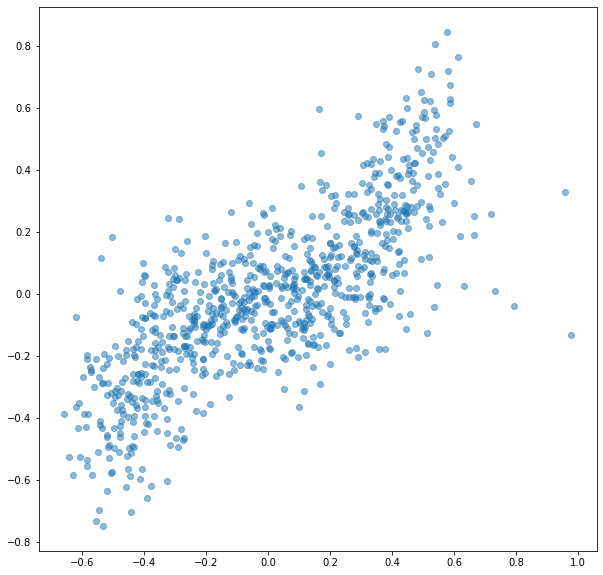

In [23]:
plt.figure(figsize=(10,10))

yhat = model(x_test).detach().numpy()
yres = (y_test-yhat)*3*s_test_y
plt.scatter(y_test[:,0],yhat[:,0],alpha=.5)

hist_x = yres[1:,0]
hist_y = yres[1:,1]

mu_x, sigma_x = norm.fit(hist_x)
mu_y, sigma_y = norm.fit(hist_y)
print('Sigma x-axis: '+str(sigma_x))
print('Sigma y-axis: '+str(sigma_y))

#np.savetxt('croci450_run_laser-20.txt', yres.numpy(), fmt='%f')